In [109]:
import torch
import torch.nn as nn
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
print(device)

cuda


In [2]:
# Helpers
class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def multi_label_acc(y_hat, y):
    return torch.count_nonzero(torch.round(y_hat) == y).item() / y.numel()

def classification_acc(y_hat, y):
    return torch.count_nonzero(torch.argmax(y_hat, dim=1) == y).item() / y.numel()

In [163]:
class Default_Model(torch.nn.Module):
    def __init__(self, num_x, num_y, depth=3, width=16, activation_func=nn.ReLU()):
        super(Default_Model, self).__init__()
        self.activation = activation_func
        self.linears = []
        prev_width = num_x
        for i in range(depth):
            if i == depth - 1:
                self.linears.append(nn.Linear(prev_width, num_y))
            else:
                if isinstance(width, list):
                    self.linears.append(nn.Linear(prev_width, width[i]))
                    prev_width = width[i]
                else:
                    self.linears.append(nn.Linear(prev_width, width))
                    prev_width = width
        self.linears = nn.Sequential(*self.linears)
    
    def forward(self, x):
        for layer_num, layer in enumerate(self.linears):
            x = layer(x)
            if layer_num < len(self.linears)-1:
                x = self.activation(x)
        return x


class FullModel(torch.nn.Module):
    def __init__(self, x_to_c_model, c_to_y_model, concept_activation=nn.Sigmoid(), label_activation=nn.Sigmoid()):
        super(FullModel, self).__init__()
        self.x_to_c_model = x_to_c_model
        self.c_to_y_model = c_to_y_model
        self.concept_activation = concept_activation
        self.label_activation = label_activation
    
    def forward(self, x):
        c_out = self.x_to_c_model(x)
        if self.concept_activation:
            c_out = self.concept_activation(c_out)
        y_out = self.c_to_y_model(c_out)
        if self.label_activation:
            y_out = self.label_activation(y_out)
        return c_out, y_out

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(random.random()*0.05-0.025)

In [164]:
x_num = 32
c_num = 32
y_num = 6
x_to_c_model = Default_Model(x_num,c_num)
c_to_y_model = Default_Model(c_num,y_num)
x_to_c_model.apply(init_weights)
c_to_y_model.apply(init_weights)
def argmax(x):
    return torch.argmax(x, dim=1)
def mult_final(x):
    return torch.argmax(torch.round((x*100)%1), dim=1)
def mult(x):
    return torch.round((x*100)%1)
full_model = FullModel(x_to_c_model, c_to_y_model, concept_activation=torch.round, label_activation=argmax)
full_model.eval()
print(full_model)

FullModel(
  (x_to_c_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=32, bias=True)
    )
  )
  (c_to_y_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Linear(in_features=16, out_features=16, bias=True)
      (2): Linear(in_features=16, out_features=6, bias=True)
    )
  )
)


In [165]:
batch_size = 32
X = torch.rand(batch_size, x_num, requires_grad=False)
c, y = full_model(X)
# print(y)
print(X[0], '\n', c[0], '\n', y)
# print(y[0]%1)

tensor([0.2816, 0.8768, 0.1781, 0.4530, 0.9060, 0.3068, 0.1451, 0.1197, 0.9946,
        0.4835, 0.5696, 0.4491, 0.8909, 0.3715, 0.9733, 0.7386, 0.1216, 0.5598,
        0.8291, 0.1776, 0.3852, 0.9920, 0.4635, 0.9295, 0.8952, 0.1572, 0.1601,
        0.0892, 0.2568, 0.8663, 0.7776, 0.4382]) 
 tensor([-0., -0., -0., -0., -0., -0., 0., 0., 0., 0., 0., 0., -0., 0., 0., 0., 0., 0., -0., 0., -0., 0., -0., 0.,
        -0., 0., -0., 0., -0., 0., -0., -0.], grad_fn=<SelectBackward0>) 
 tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2])


In [166]:
batch_size = 10**5
data_fn = 'data/synthetic_data.pkl'
X = torch.rand(batch_size, x_num, requires_grad=False)
c, y = full_model(X)
xcy = torch.concatenate([X,c,y.reshape(batch_size,1)], dim=1)
torch.save(xcy.detach(), data_fn)

In [167]:
data_fn = 'data/synthetic_data.pkl'
xcy = torch.load(data_fn, weights_only=True)
print(xcy.shape)

torch.Size([100000, 65])


# Cover Type Prediction

In [168]:
class CoverDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,:-1], self.data[idx,-1]

In [169]:
batch_size = 1024
cover_dataset = pd.read_csv('data/covertype_norm.csv', header=0, dtype=float)
Xy = torch.tensor(cover_dataset.to_numpy())

dataset = CoverDataset(Xy)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [170]:
x_num = 54
c_num = 32
y_num = 7
x_to_c_model = Default_Model(x_num,c_num, width=1024, depth=1)
c_to_y_model = Default_Model(c_num,y_num, width=512, depth=2)
x_to_c_model.apply(init_weights)
c_to_y_model.apply(init_weights)
def sigmoid_round(x):
    return torch.round(torch.nn.functional.sigmoid(x))
full_model = FullModel(x_to_c_model, c_to_y_model, concept_activation=sigmoid_round, label_activation=nn.Softmax(dim=1)).to(device)

y_criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.NAdam(full_model.parameters(), lr=0.001)
loss_meter = AverageMeter()
acc_meter = AverageMeter()

print(full_model)

FullModel(
  (x_to_c_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=54, out_features=32, bias=True)
    )
  )
  (c_to_y_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): Linear(in_features=512, out_features=7, bias=True)
    )
  )
  (label_activation): Softmax(dim=1)
)


In [171]:
epochs = 50
for epoch in range(epochs):
    loss_meter.reset()
    acc_meter.reset()
    for batch, (x, y) in enumerate(train_loader):
        x = x.float().to(device)
        y = y.squeeze().type(torch.LongTensor).to(device)
        
        c_pred, y_pred = full_model(x)

        y_loss = y_criterion(y_pred, y)
        loss = y_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), x.shape[0])
        acc_meter.update(classification_acc(y_pred, y), x.shape[0])
    
    print(f"Epoch: {epoch} Loss: {loss_meter.avg} y_acc: {acc_meter.avg}")

Epoch: 0 Loss: 1.8635830484205904 y_acc: 0.3276446107687841
Epoch: 1 Loss: 1.7416663904684175 y_acc: 0.4446559344452689
Epoch: 2 Loss: 1.7006563302312785 y_acc: 0.47972384424299125
Epoch: 3 Loss: 1.68286917239392 y_acc: 0.4917895280188405
Epoch: 4 Loss: 1.6707931484188323 y_acc: 0.503726167048424
Epoch: 5 Loss: 1.6609283382401803 y_acc: 0.5136303513243217
Epoch: 6 Loss: 1.6536845436218335 y_acc: 0.5188244023615188
Epoch: 7 Loss: 1.6465937601857352 y_acc: 0.5256637739136045
Epoch: 8 Loss: 1.6415442252892134 y_acc: 0.530664257831403
Epoch: 9 Loss: 1.636447031301741 y_acc: 0.5345678614059425
Epoch: 10 Loss: 1.631632958884685 y_acc: 0.5407942704132658
Epoch: 11 Loss: 1.6273743852275446 y_acc: 0.5439558666967771
Epoch: 12 Loss: 1.6238113806225174 y_acc: 0.5473110300996871
Epoch: 13 Loss: 1.620294474919319 y_acc: 0.5500854921444011
Epoch: 14 Loss: 1.6171212138316475 y_acc: 0.5532470884279124
Epoch: 15 Loss: 1.6131014871755738 y_acc: 0.5593444526889699
Epoch: 16 Loss: 1.610416508730094 y_acc:

In [172]:
full_model.eval()
loss_meter.reset()
acc_meter.reset()
for batch, (x, y) in enumerate(train_loader):
    x = x.float().to(device)
    y = y.squeeze().type(torch.LongTensor).to(device)
    
    c_pred, y_pred = full_model(x)

    y_loss = y_criterion(y_pred, y)
    loss = y_loss

    loss_meter.update(loss.item(), x.shape[0])
    acc_meter.update(classification_acc(y_pred, y), x.shape[0])

print(f"Test Loss: {loss_meter.avg} y_acc: {acc_meter.avg}")
print(f"Average concepts: {np.mean(c_pred.detach().cpu().numpy(), 0)}")

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., d

<Axes: >

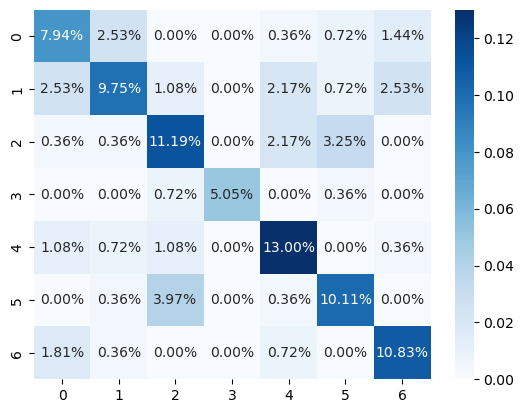

In [173]:
cf_matrix = confusion_matrix(y.detach().cpu(), y_pred.argmax(axis=1).detach().cpu())
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')

In [174]:
X = Xy[:,:-1].float().to(device)
full_model.eval()
c_pred, _ = full_model(X)
Xyc = torch.concatenate([Xy, c_pred.detach().cpu()], 1)
torch.save(Xyc, 'data/covertype_concepts.pkl')

# Optimize and find Concepts

In [4]:
class SyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, data_fn, x_num, c_num, y_num):
        self.data = torch.load(data_fn, weights_only=True)
        self.x_num = x_num
        self.c_num = c_num
        self.y_num = y_num

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx,:self.x_num], self.data[idx,self.x_num+self.c_num:], self.data[idx,self.x_num:self.x_num+self.c_num]
    

In [5]:
x_num = 32
c_num = 32
y_num = 6
batch_size = 1024
data_fn = 'data/synthetic_data.pkl'

dataset = SyntheticDataset(data_fn, x_num, c_num, y_num)
train_ratio = 0.8
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [25]:
x_to_c_model = Default_Model(x_num,c_num, depth=3, width=32)
c_to_y_model = Default_Model(c_num,y_num, depth=3, width=32)
# x_to_c_model.apply(init_weights)
# c_to_y_model.apply(init_weights)
pred_model = FullModel(x_to_c_model, c_to_y_model, concept_activation=nn.Sigmoid(), label_activation=nn.Softmax()).to(device)
print(pred_model)
c_criterion = nn.BCELoss()
c_coef = 0
y_criterion = nn.CrossEntropyLoss()
y_coef = 1
optimizer = torch.optim.Adam(pred_model.parameters(), lr=0.001)
loss_meter = AverageMeter()
y_acc_meter = AverageMeter()
c_acc_meter = AverageMeter()

FullModel(
  (x_to_c_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=32, bias=True)
    )
  )
  (c_to_y_model): Default_Model(
    (activation): ReLU()
    (linears): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Linear(in_features=32, out_features=32, bias=True)
      (2): Linear(in_features=32, out_features=6, bias=True)
    )
  )
  (concept_activation): Sigmoid()
  (label_activation): Softmax(dim=None)
)


In [26]:
epochs = 10
for epoch in range(epochs):
    loss_meter.reset()
    y_acc_meter.reset()
    c_acc_meter.reset()
    for batch, (x, y, c) in enumerate(train_loader):
        x = x.to(device)
        y = y.squeeze().type(torch.LongTensor).to(device)
        c = c.to(device)
        
        c_pred, y_pred = pred_model(x)
        # print(torch.mean(c_pred).item(), torch.mean(y_pred).item())
        # print(c_pred, '\n', y_pred)


        # c_loss = c_criterion(c_pred, c)
        y_loss = y_criterion(y_pred, y)
        loss = y_loss
        # loss = c_coef*c_loss + y_coef*y_loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_meter.update(loss.item(), x.shape[0])
        c_acc_meter.update(multi_label_acc(c_pred, c), x.shape[0])
        y_acc_meter.update(classification_acc(y_pred, y), x.shape[0])
    
    print(f"Epoch: {epoch} Loss: {loss_meter.avg} c_acc: {c_acc_meter.avg} y_acc: {y_acc_meter.avg}")

/home/coco/anaconda3/envs/cbm/lib/python3.9/site-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0 Loss: 1.6561657989501952 c_acc: 0.4998546875 y_acc: 0.5127125
Epoch: 1 Loss: 1.531499013900757 c_acc: 0.49994375 y_acc: 0.5127125
Epoch: 2 Loss: 1.53112508392334 c_acc: 0.49994375 y_acc: 0.5127125
Epoch: 3 Loss: 1.5310227848052977 c_acc: 0.49994375 y_acc: 0.5127125


KeyboardInterrupt: 

In [ ]:

loss_meter.reset()
y_acc_meter.reset()
c_acc_meter.reset()
for x, y, c in test_loader:
    x = x.to(device)
    y = y.to(device)
    c = c.to(device)
    c_pred, y_pred = pred_model(x)
    c_loss = c_criterion(c_pred, c)
    y_loss = y_criterion(y_pred, y)
    loss = c_coef*c_loss + y_coef*y_loss

    loss_meter.update(loss.item(), x.shape[0])
    c_acc_meter.update(multi_label_acc(c_pred, c), x.shape[0])
    y_acc_meter.update(classification_acc(y_pred, y), x.shape)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f"Test Loss: {loss_meter.avg} c_acc: {c_acc_meter.avg} y_acc: {y_acc_meter}")